_is an R notebook_

# Spatial Statistics - Assignment 2 (Analysing Spatial Lattice Data)

**Introduction**

This assignment is an opportunity for you to further explore the `R` programming language by working through lattice data.

The key aspects covered:

> 0) Basic Exploratory Data Analysis (EDA) and Exploratory Spatial Data Analysis (ESDA)  
> 1) Moran's I test for spatial autocorrelation  
> 2) Moran's I significance testing through simulation  
> 3) Moran's scatterplot  
> 4) Correlogram  
> 5) Local Indicators of Spatial Autocorrelation (LISA)  
> 6) Ordinary Least Squares Regression  
> 7) Geographically Weighted Regresssion (GWR)

<div class="alert alert-block alert-danger"><b>REQUIRED: </b></div>

**You are required to insert your outputs and any comment into this document.** The document you submit should therefore contain the existing text in addition to:


> *   Plots and other outputs from executing the code chunks  
> *   Discussion of your plots and other outputs as well as conclusions reached.

This should also include any hypotheses and assumptions made as well as factors that may affect your conclusions. </div>

To help you with interpreting your outputs, please consult the following resources:

|            |            | 
|------------|:-----------|
|Chapter 10 - 12:| **Introduction to geographic information systems by Kang-tsung (2011)**. A copy of this is available on Amathuba inside the Resources folder, Study Material & Books |

**GETTING STARTED**

Retrieve and set your working directory

Use the R code chunk below to:

> a) clear your R environment  
> b) print the current working directory  
> c) set your preferred working directory

In [1]:
###################################################
### Initial settings:
###################################################

rm(list=ls())
getwd()
#setwd("~/student")
options(repr.plot.width = 6, repr.plot.height = 4)

# Load the required packages
# We will use different packages to achieve different goals. The following code chunk assumes that the packages have been installed and loads the packages.

#Run install.packages("PackageName"), if the package is not installed on your computer (PackageName is the name of the package you want installed)
# Example of how to install a package:
# install.packages("rgdal")
options(scipen = 999) # turn off scientific notation (so p-values are readable)
options(digits = 4)

library(RColorBrewer)
library(classInt)
library(sp)
library(rgdal)
library(maptools)
library(spdep)
#library(spgwr)
library(PerformanceAnalytics)

[1] "C:/Users/T0084076/Downloads"

Warning message:
"package 'classInt' was built under R version 3.6.3"Warning message:
"package 'sp' was built under R version 3.6.3"

ERROR: Error in library(rgdal): there is no package called 'rgdal'


<div class="alert alert-block alert-success"><b>THE DATA: </b> </div>

This assignment is based on the  [Columbus crime data](https://search.r-project.org/CRAN/refmans/RgoogleMaps/html/columbus.html).  

In this practical you will be working with the Columbus crime data. The data set contains information on crime (combined residential burglaries and residential thefts per thousand households) as well as other variables obtained from [Columbus, OH](https://en.wikipedia.org/wiki/Columbus,_Ohio) in 1980. Unit of analysis: 49 neighbourhoods in Columbus, OH.

The variables contained in the dataset are:  
> •	AREA : computed by ArcView  
> •	PERIMETER : computed by ArcView  
> •	COLUMBUS_ : internal polygon ID (ignore)  
> •	COLUMBUS_I : another internal polygon ID (ignore)  
> •	POLYID : yet another polygon ID  
> •	NEIG : neighborhood id value (1-49); conforms to id value used in Spatial Econometrics book.  
> •	HOVAL : housing value (in 1,000dollars)  
> •	INC : household income (in 1,000dollars)  
> •	CRIME : residential burglaries and vehicle thefts per thousand households in the neighborhood  
> •	OPEN : open space in neighborhood  
> •	PLUMB : percentage housing units without plumbing  
> •	DISCBD : distance to CBD  
> •	X : x coordinate (in arbitrary digitizing units, not polygon coordinates)  
> •	Y : y coordinate (in arbitrary digitizing units, not polygon coordinates)  
> •	NSA : north-south dummy (North=1)  
> •	NSB : north-south dummy (North=1)  
> •	EW : east-west dummy (East=1)  
> •	CP : core-periphery dummy (Core=1)  
> •	THOUS : constant=1,000  
> •	NEIGNO : NEIG+1,000, alternative neighborhood id value  

The data comes in the form of a shapefile  in the `spdep` package.  

Analysis will focus on CRIME, HOVAL, INC, OPEN, PLUM, DISCBD, X and Y.

In [2]:
##############
### Read shapefile
##############
# Several packages to do this
# rgdal::readOGR
# maptools::readShapePoly

# Read data into R
#columbus <- readShapePoly(system.file("etc/shapes/columbus.shp", package="spdep")[1])
columbus <- readOGR(system.file("etc/shapes/columbus.shp", package="spdep")[1])

class(columbus) # Class of object

ERROR: Error in readOGR(system.file("etc/shapes/columbus.shp", package = "spdep")[1]): could not find function "readOGR"


In [72]:
slotNames(columbus) # Check the Components of the SpatialPolygonsDataFrame

[1] "data"        "polygons"    "plotOrder"   "bbox"        "proj4string"

In [3]:
#str(columbus)  # Full structure of the object

In [4]:
# Change map projection if necessary
#readshape <- spTransform(columbus.shp, CRS("+init=epsg:2154"))

# Example of reading shapefile and setting projection if working with your own data
#  projection <- "+proj=longlat +ellps=WGS84 +datum=WGS84"
# readshape <-readShapePoly("datashp.shp", proj4string=CRS(projection))
# The gstat package assumes that data are projected,
# i.e. they should not be provided as lattitude/longitude # and have to tell it which vectors are the corrdinates

# The command below specifies the coordinates and changes the dataframe
# to a "SpatialPointDataFrame", which is necessary for variogram modelling

## 0. Exploratory Data Analysis (EDA) and Exploratory Spatial Data Analysis (ESDA)

It is always advisable to **visualise your data** prior to more formal analysis.
EDA and ESDA will help assess:

> •	the key characteristics of the data including possible data errors  
> •	the existence and location of nonrandom local patterns in the data  
> •	the presence of any outliers

Also useful in suggesting pottential associations between variables.
EDA and ESDA cannot _explain_ the observed patterns.

Formal testing of hypothesis should be carried out by means of multivariate regression modelling.


In [74]:
#pacman::p_unload(graphics)
## The following packages are a base install and will not be unloaded:
## graphics
#Extract the data frame from your shapefile
columbusdata <- columbus@data

class(columbusdata) # Class of object

[1] "data.frame"

In [75]:
names(columbusdata) # Names of variables

[1] "AREA"       "PERIMETER"  "COLUMBUS_"  "COLUMBUS_I" "POLYID"    
 [6] "NEIG"       "HOVAL"      "INC"        "CRIME"      "OPEN"      
[11] "PLUMB"      "DISCBD"     "X"          "Y"          "NSA"       
[16] "NSB"        "EW"         "CP"         "THOUS"      "NEIGNO"

In [76]:
str(columbusdata)   # Structure of the object (gives you details of variable types)

'data.frame':	49 obs. of  20 variables:
 $ AREA      : num  0.3094 0.2593 0.1925 0.0838 0.4889 ...
 $ PERIMETER : num  2.44 2.24 2.19 1.43 3 ...
 $ COLUMBUS_ : Factor w/ 49 levels "10","11","12",..: 11 22 33 44 46 47 48 49 1 2 ...
 $ COLUMBUS_I: Factor w/ 49 levels "1","10","11",..: 45 1 46 12 47 48 34 23 10 2 ...
 $ POLYID    : Factor w/ 49 levels "1","10","11",..: 1 12 23 34 45 46 47 48 49 2 ...
 $ NEIG      : int  5 1 6 2 7 8 4 3 18 10 ...
 $ HOVAL     : num  80.5 44.6 26.4 33.2 23.2 ...
 $ INC       : num  19.53 21.23 15.96 4.48 11.25 ...
 $ CRIME     : num  15.7 18.8 30.6 32.4 50.7 ...
 $ OPEN      : num  2.851 5.297 4.535 0.394 0.406 ...
 $ PLUMB     : num  0.217 0.321 0.374 1.187 0.625 ...
 $ DISCBD    : num  5.03 4.27 3.89 3.7 2.83 3.78 2.74 2.89 3.17 4.33 ...
 $ X         : num  38.8 35.6 39.8 36.5 40 ...
 $ Y         : num  44.1 42.4 41.2 40.5 38 ...
 $ NSA       : num  1 1 1 1 1 1 1 1 1 1 ...
 $ NSB       : num  1 1 1 1 1 1 1 1 1 1 ...
 $ EW        : num  1 0 1 0 1 1 0 0 1 1

<div class="alert alert-block alert-warning"><b>TASK / QUESTIONS: </b> </div>

*   Create a subset data from the columbusdata (select relevant variables and generate summary statistics etc.). Select the numerical variables in columns 7 to 12 and store the subset data into columbusdata_sub variable. Use the summary function to print the summary statistics.

In [78]:
# [double click in this cell and type your code to create `columbusdata_sub` here]

# perhaps something like:
#split_veg <- c("HOVAL", "INC", "CRIME", "OPEN", "PLUMB", "DISCBD")

columbusdata_sub <- columbusdata[,c(7, 8, 9, 10, 11, 12)]
head(columbusdata_sub, 3)

,HOVAL,INC,CRIME,OPEN,PLUMB,DISCBD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,80.47,19.53,15.73,2.851,0.2172,5.03
1,44.57,21.23,18.80,5.297,0.3206,4.27
2,26.35,15.96,30.63,4.535,0.3744,3.89


*   What is the mean, maximum and minimum variable for each data set?

> [double click in this cell and type your answer]


*   Print out the correlation matrix and the correlation plot.




> [double click in this cell and type your answer]

In [79]:
cor(columbusdata_sub) # Correlation

,HOVAL,INC,CRIME,OPEN,PLUMB,DISCBD
HOVAL,1.0000,0.4999,-0.57449,0.25176,-0.0204,0.48519
INC,0.4999,1.0000,-0.69559,0.15322,-0.2561,0.60033
CRIME,-0.5745,-0.6956,1.00000,-0.06526,0.4327,-0.74078
OPEN,0.2518,0.1532,-0.06526,1.00000,0.1920,0.02023
PLUMB,-0.0204,-0.2561,0.43269,0.19201,1.0000,-0.57218
DISCBD,0.4852,0.6003,-0.74078,0.02023,-0.5722,1.00000


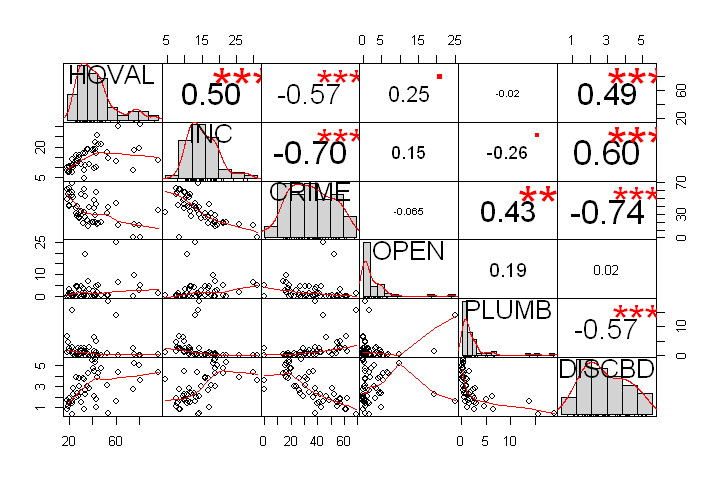

In [80]:
# Correlation plot using PerformanceAnalytic package
chart.Correlation(columbusdata_sub, histogram=TRUE, pch=19)

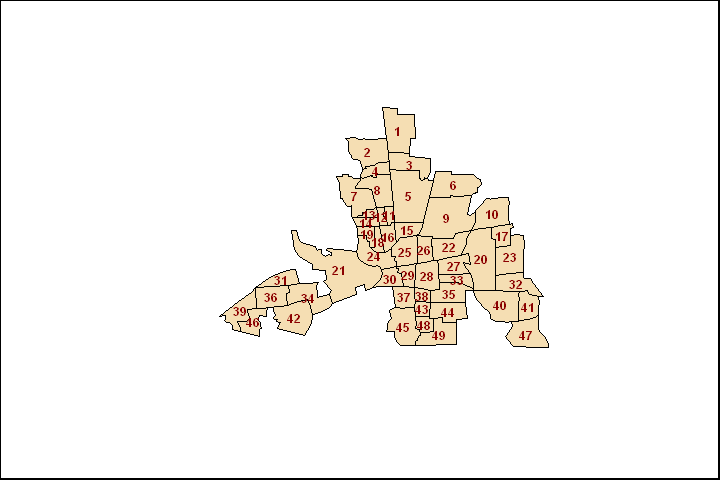

In [81]:
# Plot the zones from the Columbus, Ohio data

plot(columbus,col='wheat') # Create a plot of columbus
# Add labels for each of the zones
text(coordinates(columbus),
     labels=as.character(columbus@data$POLYID),
     cex=0.6,font=2, col="darkred")
box(which='outer',lwd=2)

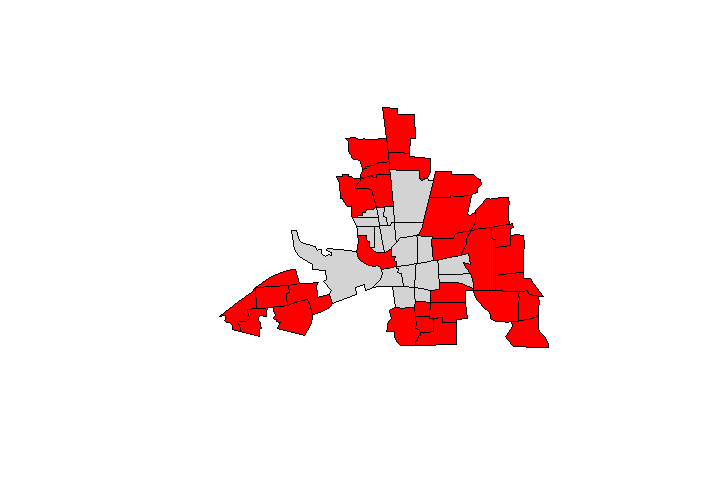

In [82]:
# Visualising a variable - Binary classification
plot(columbus, col = ifelse(columbus$CRIME > 40, "lightgrey", "red"))

<div class="alert alert-block alert-warning"><b>QUESTION: </b> </div>


*   What conclusion/s can you draw about the data distribution (provide the plot)?

> [double click in this cell and type your answer]

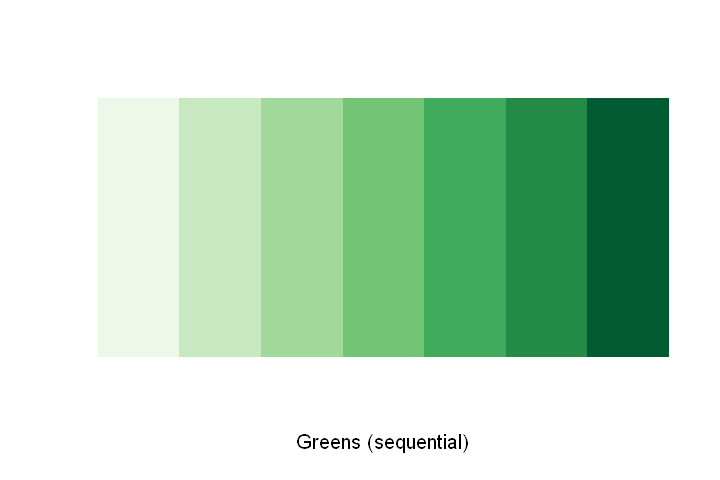

In [83]:
# You could view your data using a more detailed classification
# Select Color scale - Create a Palette
pal = brewer.pal(7,"Greens") # Makes a 7-color spectral palette
display.brewer.pal(7, "Greens")  # This displays the colors

In [84]:
# Classifying Data using classIntervals()
# Create class breaks
brks.eq = classIntervals(columbus$CRIME, n = 7, style = "equal")
brks.qt = classIntervals(columbus$CRIME, n = 7, style = "quantile")
brks.jk = classIntervals(columbus$CRIME, n = 7, style = "jenks")
# Other style options "fixed", "sd", "pretty", "kmeans", "hclust", "bclust" and "fisher

In [85]:
# Link the color pallette to the class breaks (categories) using
# findColours(CATEGORIES,PALETTE)
brks.eqcol = findColours(brks.eq, pal)
brks.qtcol = findColours(brks.qt, pal)
brks.jkcol = findColours(brks.jk, pal)

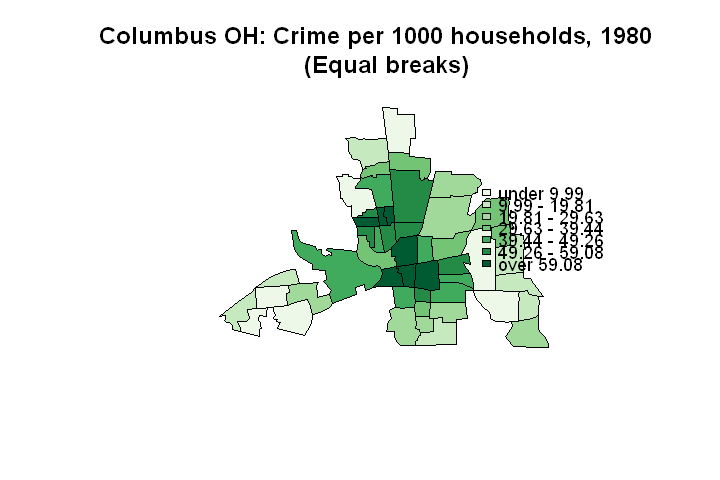

In [89]:
# Plot with Equal Breaks
plot(columbus,  col=brks.qtcol, border="black")
legend("right", leglabs(round(brks.eq$brks, digits=2)), fill=pal, cex=0.9, bty="n")
title(main="Columbus OH: Crime per 1000 households, 1980  \n (Equal breaks)")

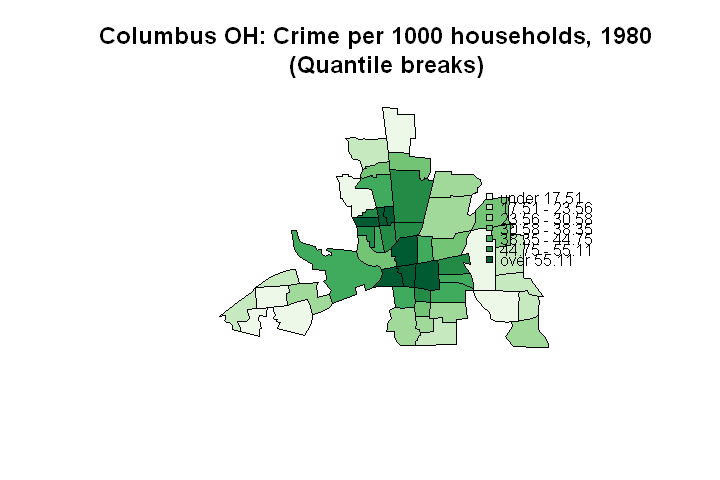

In [90]:
# Plot with Quantile Breaks
plot(columbus,  col=brks.qtcol, border="black")
legend("right",leglabs(round(brks.qt$brks,digits=2)), fill=pal, cex=0.8, bty="n")
title(main="Columbus OH: Crime per 1000 households, 1980  \n (Quantile breaks)")

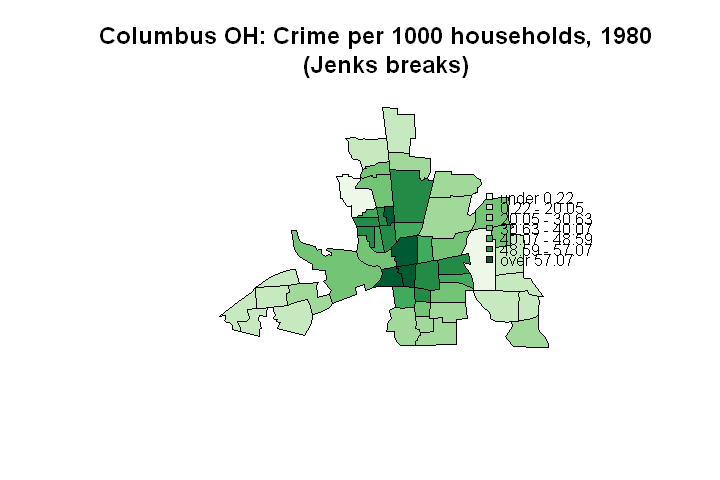

In [91]:
# Plot with Jenks Breaks
plot(columbus,  col=brks.jkcol, border="black")
legend("right",leglabs(round(brks.jk$brks,digits=2)), fill=pal, cex=0.8, bty="n")
title(main="Columbus OH: Crime per 1000 households, 1980  \n (Jenks breaks)", cex=0.5)

<div class="alert alert-block alert-warning"><b>QUESTION: </b> </div>

*   What conclusions can you draw from the data distribution? And What is the difference between the plots?

> [double click in this cell and type your answer]



**Constructing your spatial weight matrix**


In [92]:
######
# Constructing weight matrix from shapefile
# To deduce neighbourhood structure from spatial polygons by poly2nb
######

columbus.nb = poly2nb(columbus, queen = T)  # Queen's case is the default. To change to Rook's case, set "queen = F i.e  columbus.nb = poly2nb(columbus, queen = F)

#row standardize the weight matrix
columbus.wts = nb2listw(columbus.nb, style="W")
m = length(columbus$CRIME)
s = Szero(columbus.wts)

# Explore the weight matrix
summary(columbus.wts)

Characteristics of weights list object:
Neighbour list object:
Number of regions: 49 
Number of nonzero links: 236 
Percentage nonzero weights: 9.829 
Average number of links: 4.816 
Link number distribution:

 2  3  4  5  6  7  8  9 10 
 5  9 12  5  9  3  4  1  1 
5 least connected regions:
0 5 41 45 46 with 2 links
1 most connected region:
19 with 10 links

Weights style: W 
Weights constants summary:
   n   nn S0    S1    S2
W 49 2401 49 22.75 203.7


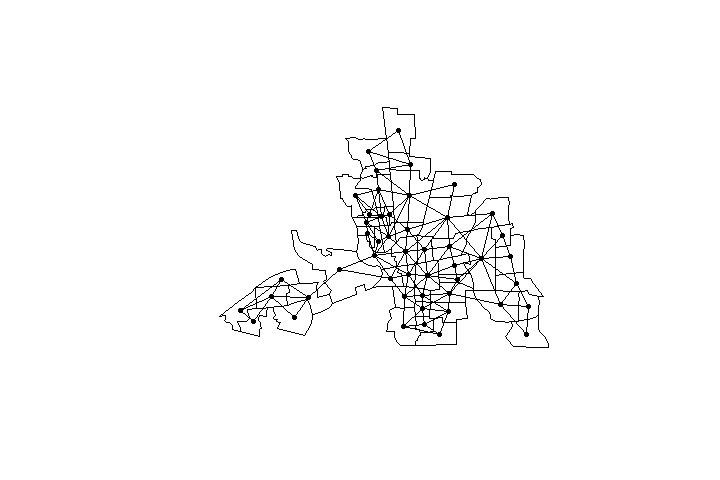

In [93]:
# coordinates function extracts coordinates of the shapefile
columbuscoords <- coordinates(columbus)
plot(columbus)
plot(columbus.wts, columbuscoords, pch=19, cex=0.6, add=TRUE)

<div class="alert alert-block alert-warning"><b>QUESTION / COMMENTS: </b> </div>



*   What is the average number of links? List the number of least and most connected regions. Provide the weight plot

> [double click in this cell and write your answer here]

## 1. Examine Spatial Autocorrelation


Compute Moran's I for the CRIME variable  

**Null Hypothesis**: There is no spatial autocorrelation for the CRIME variable.

**Alt Hypothesis**: There is spatial autocorrelation for the CRIME variable


In [94]:
moran(columbus$CRIME, columbus.wts, n = m, S0 = s)

$I
[1] 0.5002

$K
[1] 2.226

In [95]:
moran.test(columbus$CRIME, columbus.wts)


	Moran I test under randomisation

data:  columbus$CRIME  
weights: columbus.wts    

Moran I statistic standard deviate = 5.6, p-value = 0.00000001
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
         0.500189         -0.020833          0.008689 


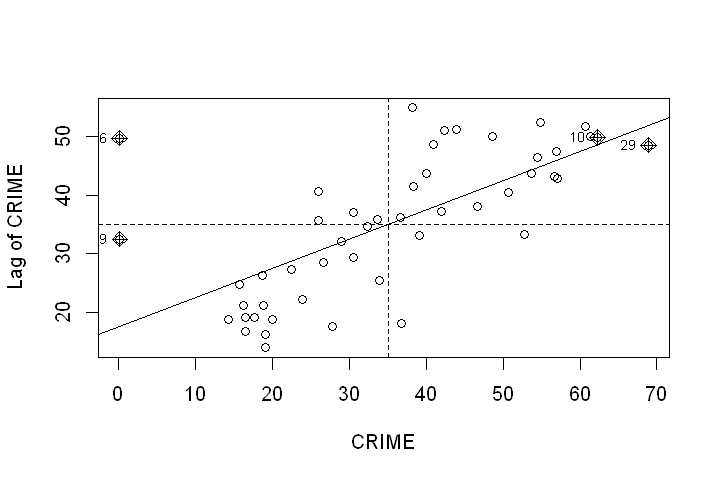

In [96]:
# Moran Scatterplot
columbusmp <- moran.plot(columbus$CRIME, columbus.wts,
                         labels = as.character(columbus.wts$POLYID),
                         xlab = "CRIME", ylab = "Lag of CRIME")

<div class="alert alert-block alert-warning"><b>QUESTION / COMMENTS: </b> </div>



*   Testing Significance of Moran's I Statistic under randomization. What conclusion can you draw from the p-value and from the Moran scatterplot?.

> [double click in this cell and write your answer here]

## 4. Spatial Correlograms

The spatial correlogram is also a useful tool for examining if autocorrelation is a local pheonomena (only present among close neighbors) or if it extends over the entire study area (higher order neighbors).

They show how correlated are pairs of spatial observations when you increase the distance (lag) between them. Significant lags are those that do not cross the horizontal line and are strictly above zero.

In [97]:
columbus_cor5 <- sp.correlogram(columbus.nb, columbus$CRIME, order = 5, method = "I")
columbus_cor5

Spatial correlogram for columbus$CRIME 
method: Moran's I
       estimate expectation variance standard deviate Pr(I) two sided    
1 (49)  0.50019    -0.02083  0.00869             5.59     0.000000023 ***
2 (49)  0.14493    -0.02083  0.00536             2.26           0.024 *  
3 (49) -0.15226    -0.02083  0.00424            -2.02           0.044 *  
4 (49) -0.31531    -0.02083  0.00383            -4.76     0.000001946 ***
5 (49) -0.45613    -0.02083  0.00612            -5.57     0.000000026 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

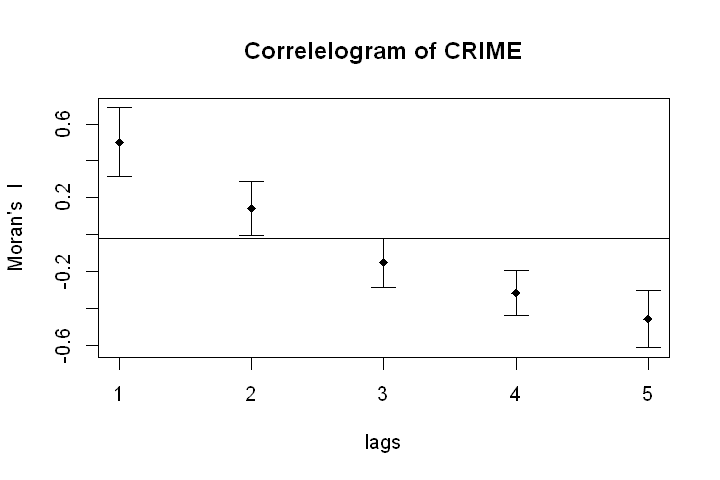

In [98]:
plot(columbus_cor5, main = "Correlelogram of CRIME")

<div class="alert alert-block alert-warning"><b>QUESTION / COMMENTS: </b> </div>

*   What conclusion can you draw from the correlelogram plot, post the summary of the results from Spatial correlogram for `columbus$CRIME`.

> [double click in this cell and write your answer here]

## 5. Local Indicators of Spatial Autocorrelation (LISA)

In [99]:
### Local Moran's I
columbus_locm <- localmoran(columbus$CRIME, columbus.wts)

CRIME <- scale(columbus$CRIME)
columbus$lag_sCRIME <- lag.listw(columbus.wts, CRIME)

In [100]:
# Identify the Moran plot quadrant for each observation
columbus$quad_sig <- NA
columbus[(columbus$CRIME >= 0 & columbus$lag_sCRIME >= 0) & (columbus_locm[, 5] <= 0.05),
         "quad_sig"] <- 1
columbus[(columbus$CRIME <= 0 & columbus$lag_sCRIME <= 0) & (columbus_locm[, 5] <= 0.05),
         "quad_sig"] <- 2
columbus[(columbus$CRIME >= 0 & columbus$lag_sCRIME <= 0) & (columbus_locm[, 5] <= 0.05),
         "quad_sig"] <- 3
columbus[(columbus$CRIME <= 0 & columbus$lag_sCRIME >= 0) & (columbus_locm[, 5] <= 0.05),
         "quad_sig"] <- 4
columbus[(columbus_locm[, 5] > 0.05), "quad_sig"] <- 5

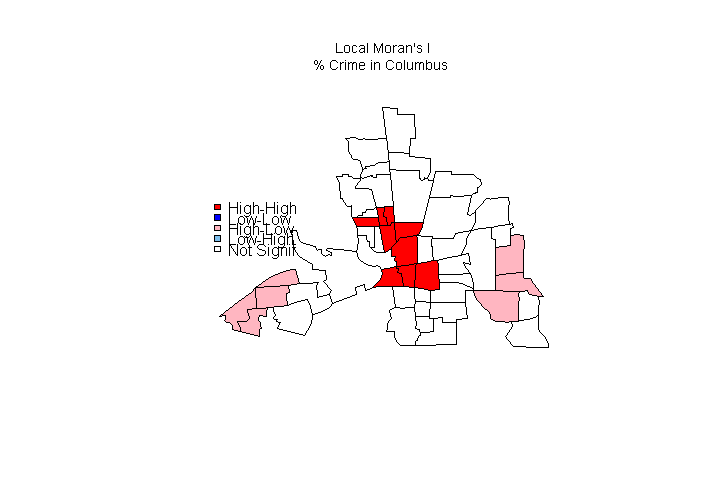

In [101]:
#Plot Results
breaks <- seq(1, 5, 1)
labels <- c("High-High", "Low-Low", "High-Low", "Low-High", "Not Signif.")
np <- findInterval(columbus$quad_sig, breaks)
colors <- c("red", "blue", "lightpink", "skyblue2", "white")
plot(columbus, col = colors[np])
mtext("Local Moran's I\n% Crime in Columbus ", cex = 0.7, side = 3,
      line = 1)
legend("left", legend = labels, fill = colors, bty = "n",cex = 0.8)

<div class="alert alert-block alert-warning"><b>QUESTIONS / COMMENTS: </b> </div>



*   Paste the summary of `columbus_locm`, `CRIME`, and `columbus$lag_sCRIME` results on your report. Also, provide the plot of results on your report.



> [double click in this cell and write your answer here]

**Create a non-spatial model for predicting CRIME and do some diagnostics**

In [102]:
# OLS Regression to predict CRIME using INC and HOVAL as independent variables
reg1 <- lm(columbusdata$CRIME ~ columbusdata$INC + columbusdata$HOVAL )

In [103]:
# Moran's I on the residuals 
moran.test(reg1$residuals, columbus.wts, alternative="two.sided")


	Moran I test under randomisation

data:  reg1$residuals  
weights: columbus.wts    

Moran I statistic standard deviate = 2.7, p-value = 0.008
alternative hypothesis: two.sided
sample estimates:
Moran I statistic       Expectation          Variance 
         0.222109         -0.020833          0.008391 


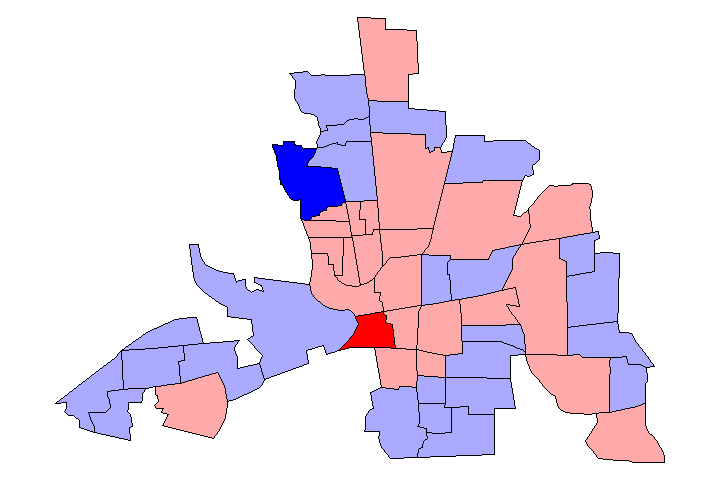

In [105]:
# Plot the residuals
res <- residuals(reg1)
classes_sd <- classIntervals(res, n=4, style = "sd", rtimes = 1, dataPrecision = 3)
res.palette <- colorRampPalette(c("blue","white","red"), space = "rgb")
pal <- res.palette(4)
cols <- findColours(classes_sd, pal)
par(mar=rep(0, 4))
plot(columbus, col=cols)#, main="Residuals from OLS Model")#, border="grey")
legend("bottomright",cex=0.7,fill=attr(cols,"palette"), bty="n",
       legend=names(attr(cols, "table")), title="Residuals from OLS Model",ncol=4)

<div class="alert alert-block alert-warning"><b>QUESTIONS / COMMENTS: </b> </div>



*   What conclusion can you draw from the Multiple and Adjusted R-squared. Paste the summary of reg1 results on your report?

> [double click in this cell and write your answer here]

- Is there autocorrelation in the residuals? provide the plot of the residuals? Paste the results of the Moran’s I on your report.

>

<div class="alert alert-block alert-danger"><b> Stop here.</b> </div>

## 7. Geographically weighted regression

For this section, we use the `spgwr` package.

**Aim:** Fit a regression model at each location using observations inversely weighted by their distance to the location. This results in one set of coefficients for each observation.

We fit the same model as before: `CRIME ~ INC + HOVAL`.  

<div class="alert alert-block alert-info"><b>NOTE: </b>  </div>

> The x and y values represent the centroids of the census tracts.
> The first step is to determine the kernel bandwidth. The default kernel is Gaussian. The kernel together with the bandwidth specify the matrix of weights.

In [106]:
#library(spgwr)
data(columbus)
names(columbus)

[1] "AREA"       "PERIMETER"  "COLUMBUS."  "COLUMBUS.I" "POLYID"    
 [6] "NEIG"       "HOVAL"      "INC"        "CRIME"      "OPEN"      
[11] "PLUMB"      "DISCBD"     "X"          "Y"          "AREA"      
[16] "NSA"        "NSB"        "EW"         "CP"         "THOUS"     
[21] "NEIGNO"     "PERIM"

In [37]:
# GWR with Gauss
columbus.bw <- gwr.sel(crime ~ income + housing,
                  data=columbus,
                  coords=cbind(columbus$X, columbus$Y))

ERROR: Error in gwr.sel(crime ~ income + housing, data = columbus, coords = cbind(columbus$x, : could not find function "gwr.sel"


In [108]:
# GWR with Gauss
columbus.bw <- gwr.sel(columbus$CRIME ~ columbus$INC + columbus$HOVAL,
                  data=columbus,
                  coords=cbind(columbus$X, columbus$Y))

ERROR: Error in gwr.sel(columbus$CRIME ~ columbus$INC + columbus$HOVAL, data = columbus, : could not find function "gwr.sel"


In [59]:
columbus.lm <- lm(columbus$CRIME ~ columbus$INC + columbus$HOVAL, 
               data=columbus)
summary(columbus.lm)


Call:
lm(formula = columbus$CRIME ~ columbus$INC + columbus$HOVAL, 
    data = columbus)

Residuals:
   Min     1Q Median     3Q    Max 
-34.42  -6.39  -1.58   9.05  28.65 

Coefficients:
               Estimate Std. Error t value             Pr(>|t|)    
(Intercept)      68.619      4.735   14.49 < 0.0000000000000002 ***
columbus$INC     -1.597      0.334   -4.78             0.000018 ***
columbus$HOVAL   -0.274      0.103   -2.65                0.011 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 11.4 on 46 degrees of freedom
Multiple R-squared:  0.552,	Adjusted R-squared:  0.533 
F-statistic: 28.4 on 2 and 46 DF,  p-value: 0.00000000934


In [60]:
names(columbus.lm)

[1] "coefficients"  "residuals"     "effects"       "rank"         
 [5] "fitted.values" "assign"        "qr"            "df.residual"  
 [9] "xlevels"       "call"          "terms"         "model"

In [63]:
# Add the fitted values as a new column in the dataframe
columbus$columbus$CRIME.lm <- columbus.lm$fitted.values

In [68]:
#head(columbus, 1)

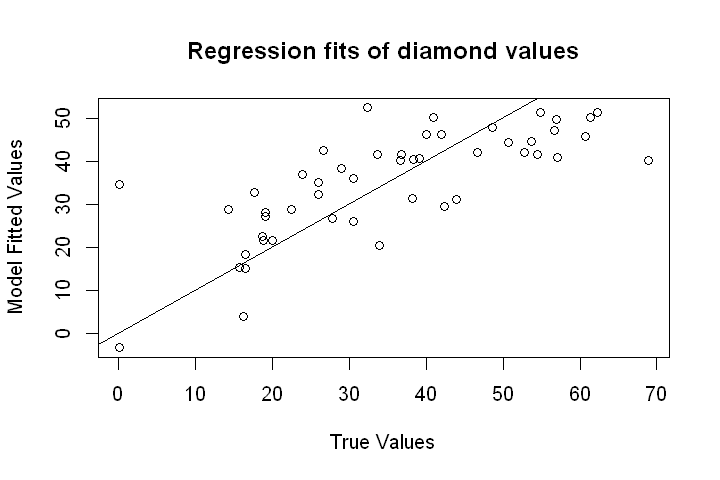

In [67]:
# Plot the relationship between true diamond values
#   and linear model fitted values

plot(x = columbus$CRIME,                          # True values on x-axis
     y = crime.lm$fitted.values,               # fitted values on y-axis
     xlab = "True Values",
     ylab = "Model Fitted Values",
     main = "Regression fits of diamond values")

abline(b = 1, a = 0)                             # Values should fall around this line!

In [38]:
Next fit a geographic regression. This is done with the gwr() function.
# Brackets around the code prints the results
(crime.gauss <- gwr(crime ~ income + housing,
                  data=columbus,
                  coords=cbind(columbus$x, columbus$y),
                  bandwidth=crime.bw))


ERROR: Error in parse(text = x, srcfile = src): <text>:1:6: unexpected symbol
1: Next fit
         ^


In [ ]:
# Distribution of betas

d <- cbind(crime.gauss$SDF$income,crime.gauss$SDF$housing)

par(mar=c(3,4,2,2))
boxplot(d,xaxt="n",yaxt="n",pars=list(boxwex=0.3))
axis(1,at=1:2,label=c("Income","Housing"))
axis(2,at=seq(-4,2,.2),las=1)
abline(h=0,lty="4343",col="#7E7E7E")
mtext("Beta i",2,line=3)


In [ ]:
#-- update with spatialreg
library(spatialreg)
data(columbus)

crime.bw <- bw.reg(columbus$CRIME ~ columbus$INC + columbus$HOVAL, 
                   data=columbus,
                   coords=cbind(columbus$X, columbus$Y),
                   method="cv")

crime.gwr <- GWR(CRIME ~ INC + HOVAL,
                 data=columbus,
                 coords=cbind(columbus$X, columbus$Y),
                 bandwidth=crime.bw)

# Distribution of betas
d <- cbind(crime.gwr$SDF$INC, crime.gwr$SDF$HOVAL)
d

# Plot
par(mar=c(3,4,2,2))
boxplot(d, xaxt="n", yaxt="n", pars=list(boxwex=0.3))
axis(1, at=1:2, label=c("Income", "Housing"))
axis(2, at=seq(-4, 2, 0.2), las=1)
abline(h=0, lty="4343", col="#7E7E7E")
mtext("Beta i", 2, line=3)

<div class="alert alert-block alert-warning"><b>QUESTIONS / COMMENTS: </b> </div>



*   Provide your own code that plots the geographic weighted regression (gwr), paste the plotted model and draw a conclusion



> [double click in this cell and discuss the results here]



*   What conclusion can you draw from the boxplot? (paste the plot on your report)



> [double click in this cell and discuss the results here]